# Import libaries and load ALL files into Colab

In [51]:
import numpy as np
import pandas as pd
import tensorflow as tf
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
import os
from PIL import Image
import matplotlib.pyplot as plt

In [29]:
# run this if you are using colab
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
# if this does not run, change to the file path where ALL is located on your device
!unzip gdrive/MyDrive/ALL.zip

Streaming output truncated to the last 5000 lines.
  inflating: ALL/all_pro/all_pro_4792.jpg  
  inflating: __MACOSX/ALL/all_pro/._all_pro_4792.jpg  
  inflating: ALL/all_pro/all_pro_1832.jpg  
  inflating: __MACOSX/ALL/all_pro/._all_pro_1832.jpg  
  inflating: ALL/all_pro/all_pro_0292.jpg  
  inflating: __MACOSX/ALL/all_pro/._all_pro_0292.jpg  
  inflating: ALL/all_pro/all_pro_3943.jpg  
  inflating: __MACOSX/ALL/all_pro/._all_pro_3943.jpg  
  inflating: ALL/all_pro/all_pro_2485.jpg  
  inflating: __MACOSX/ALL/all_pro/._all_pro_2485.jpg  
  inflating: ALL/all_pro/all_pro_3957.jpg  
  inflating: __MACOSX/ALL/all_pro/._all_pro_3957.jpg  
  inflating: ALL/all_pro/all_pro_2491.jpg  
  inflating: __MACOSX/ALL/all_pro/._all_pro_2491.jpg  
  inflating: ALL/all_pro/all_pro_0286.jpg  
  inflating: __MACOSX/ALL/all_pro/._all_pro_0286.jpg  
  inflating: ALL/all_pro/all_pro_1198.jpg  
  inflating: __MACOSX/ALL/all_pro/._all_pro_1198.jpg  
  inflating: ALL/all_pro/all_pro_1826.jpg  
  inflating: _

In [34]:
data_dir = 'ALL'

# Setup for turning ALL folder into train, validate, and test sets
Start with turning the folders into separate datasets, each with a label for each image. Then, create dataloaders using those datasets

In [22]:
# Update the class_to_label dictionary based on the actual directories found.
# The previous output showed 'all_pro', 'all_pre', 'all_benign', 'all_early'
class_to_label = {'all_benign': 0, 'all_early': 1, 'all_pre': 2, 'all_pro': 3}


class ALLDatasetSplit(Dataset):
    def __init__(self, image_files, labels, transform=None):
        self.image_files = image_files
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

all_image_files = []
all_labels = []

# Iterate through each folder in ALL
for class_name in os.listdir(data_dir):
    class_dir = os.path.join(data_dir, class_name)
    if os.path.isdir(class_dir):
        if class_name in class_to_label: # Only process directories that are in the class_to_label map
            # Assign image_file to all_image_files and class labels all_labels
            for image_file in os.listdir(class_dir):
                all_image_files.append(os.path.join(class_dir, image_file))
                all_labels.append(class_to_label[class_name])
        else:
            print(f"Warning: Directory '{class_name}' not found in class_to_label and will be skipped.")


# Use a fixed seed for reproducibility
np.random.seed(123)
indices = np.arange(len(all_image_files))
# Shuffle indices so not all images of one ALL folder are in the same training/validation/test set
np.random.shuffle(indices)

# Determine split points
train_split = int(0.7 * len(indices))
val_split = int(0.7 * len(indices) + 0.15 * len(indices))

train_indices = indices[:train_split]
val_indices = indices[train_split:val_split]
test_indices = indices[val_split:]

# Create lists of file paths and labels for each set
# Training data gets first 70% of indicies
train_files = [all_image_files[i] for i in train_indices]
train_labels = [all_labels[i] for i in train_indices]

# Validation data gets the next 15% of indices
val_files = [all_image_files[i] for i in val_indices]
val_labels = [all_labels[i] for i in val_indices]

# Testing data gets tthe last 15% of indices
test_files = [all_image_files[i] for i in test_indices]
test_labels = [all_labels[i] for i in test_indices]

# Create dataset instances
train_dataset = ALLDatasetSplit(train_files, train_labels, transform=transform)
val_dataset = ALLDatasetSplit(val_files, val_labels, transform=transform)
test_dataset = ALLDatasetSplit(test_files, test_labels, transform=transform)

print(f"Number of training images: {len(train_dataset)}")
print(f"Number of validation images: {len(val_dataset)}")
print(f"Number of test images: {len(test_dataset)}")

Number of training images: 14000
Number of validation images: 3000
Number of test images: 3000


In [10]:
# Create PyTorch DataLoaders
batch_size = 32

# Shuffle only for train loader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Number of batches in train_loader: {len(train_loader)}")
print(f"Number of batches in val_loader: {len(val_loader)}")
print(f"Number of batches in test_loader: {len(test_loader)}")

Number of batches in train_loader: 438
Number of batches in val_loader: 94
Number of batches in test_loader: 94


# Different Convolutional Neural Network Models

In [25]:
# Initial CNN model with 2 convolution layers and 1 pooling layer
class ALLCNN1(nn.Module):
    def __init__(self, num_classes=4):
        super(ALLCNN1, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3) # (128, 128) to (126, 126), 32 feature maps
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3) # (126, 126) to (124, 124), 64 feature maps
        self.pool = nn.MaxPool2d(kernel_size=2) # (124, 124) to (62, 62), 128 feature maps
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64 * 62 * 62, 128)
        self.fc2 = nn.Linear(128, num_classes) # 128 feature maps to outputs

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [47]:
# ALLCNN2 adds a dropout layer
class ALLCNN2(nn.Module):
    def __init__(self, num_classes=4):
        super(ALLCNN2, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3) # (128, 128) to (126, 126), 32 feature maps
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3) # (126, 126) to (124, 124), 64 feature maps
        self.pool = nn.MaxPool2d(kernel_size=2) # (124, 124) to (62, 62), 128 feature maps
        self.dropout1 = nn.Dropout(0.25) # 25% for hidden layer
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64 * 62 * 62, 128)
        self.fc2 = nn.Linear(128, num_classes) # 128 feature maps to outputs

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = self.dropout1(x)
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [26]:
# use GPU if available
if torch.cuda.is_available():
  print("GPU detected")
  device = torch.device("cuda")
else:
  print("No GPU detected")
  device = torch.device("cpu")

GPU detected


# Functions for training the model

In [32]:
# Get accuracy and loss for one epoch
# train_epoch and validate_epoch are both helper functions for train_model

def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_acc = 100 * correct / total
    epoch_loss = running_loss / len(train_loader)
    return epoch_acc, epoch_loss

def validate_epoch(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    epoch_acc = 100 * correct / total
    epoch_loss = running_loss / len(val_loader)
    return epoch_acc, epoch_loss


In [42]:
def train_model(model, criterion, optimizer):
  model.to(device)
  num_epochs = 15

  # Move optimizer state to the same device as the model
  for state in optimizer.state.values():
      for k, v in state.items():
          if isinstance(v, torch.Tensor):
              state[k] = v.to(device)

  # Early stopping parameters
  patience = 3  # Number of epochs to wait for improvement

  best_val_loss = float('inf')
  epochs_no_improve = 0
  best_model_wts = None # Initialize best model weights

  for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = validate_epoch(model, val_loader, criterion, device)

    print(f'Epoch {epoch+1}: Train Acc: {train_acc:.2f}%, Train Loss: {train_loss:.4f}, Val Acc: {val_acc:.2f}%, Val Loss: {val_loss:.4f}')

    # Early stopping logic and saving best model
    if val_loss < best_val_loss:
      best_val_loss = val_loss
      epochs_no_improve = 0
      best_model_wts = model.state_dict() # Save the best model weights
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
          print(f'Early stopping after {epoch+1} epochs as validation loss did not improve for {patience} consecutive epochs.')
          break  # Stop training

  # Load the best model weights after training
  if best_model_wts:
    model.load_state_dict(best_model_wts)
  return model # Return the trained model (with best weights loaded)

# Train all models and perform cross-validation

In [55]:
# Train ALLCNN1

model1 = ALLCNN1(num_classes=4)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model1.parameters(), lr=0.001)

train_model(model1, criterion, optimizer)

Epoch 1: Train Acc: 70.21%, Train Loss: 0.7659, Val Acc: 83.43%, Val Loss: 0.3764
Epoch 2: Train Acc: 86.79%, Train Loss: 0.3089, Val Acc: 89.60%, Val Loss: 0.2761
Epoch 3: Train Acc: 94.46%, Train Loss: 0.1481, Val Acc: 87.57%, Val Loss: 0.3191
Epoch 4: Train Acc: 96.54%, Train Loss: 0.0954, Val Acc: 94.77%, Val Loss: 0.1400
Epoch 5: Train Acc: 97.46%, Train Loss: 0.0690, Val Acc: 94.37%, Val Loss: 0.1564
Epoch 6: Train Acc: 97.94%, Train Loss: 0.0593, Val Acc: 95.13%, Val Loss: 0.1841
Epoch 7: Train Acc: 99.04%, Train Loss: 0.0315, Val Acc: 95.20%, Val Loss: 0.1618
Early stopping after 7 epochs as validation loss did not improve for 3 consecutive epochs.


ALLCNN1(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=246016, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=4, bias=True)
)

In [58]:
# Evaluate trained ALLCNN1 model on the test set
test_loss, test_acc = validate_epoch(model1, test_loader, criterion, device)
print(f'ALLCNN1 Test Acc: {test_acc:.2f}%, Test Loss: {test_loss:.4f},')

ALLCNN1 Test Acc: 95.30%, Test Loss: 0.1608,


In [48]:
# Train ALLCNN2

model2 = ALLCNN2(num_classes=4)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model2.parameters(), lr=0.001)

train_model(model2, criterion, optimizer)

Epoch 1: Train Acc: 66.91%, Train Loss: 0.8627, Val Acc: 84.70%, Val Loss: 0.4057
Epoch 2: Train Acc: 87.91%, Train Loss: 0.3149, Val Acc: 83.80%, Val Loss: 0.3723
Epoch 3: Train Acc: 92.84%, Train Loss: 0.1877, Val Acc: 89.57%, Val Loss: 0.2841
Epoch 4: Train Acc: 95.04%, Train Loss: 0.1413, Val Acc: 90.70%, Val Loss: 0.2346
Epoch 5: Train Acc: 96.86%, Train Loss: 0.0877, Val Acc: 88.77%, Val Loss: 0.3298
Epoch 6: Train Acc: 97.83%, Train Loss: 0.0732, Val Acc: 90.17%, Val Loss: 0.3584
Epoch 7: Train Acc: 98.56%, Train Loss: 0.0454, Val Acc: 90.33%, Val Loss: 0.3996
Early stopping after 7 epochs as validation loss did not improve for 3 consecutive epochs.


ALLCNN2(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.25, inplace=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=246016, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=4, bias=True)
)

In [49]:
# Evaluate trained ALLCNN2 model on the test set
test_loss, test_acc = validate_epoch(model, test_loader, criterion, device)
print(f'ALLCNN2 Test Acc: {test_acc:.2f}%, Test Loss: {test_loss:.4f},')

ALLCNN2 Test Acc: 90.17%, Test Loss: 0.4016,


# Data Visualizations

In [52]:
# Feature map visualization function
def visualize_feature_maps(model, image):
    model.eval()
    with torch.no_grad():
        # Pass image through the first conv layer
        x = model.conv1(image.unsqueeze(0))

    # Get feature maps
    feature_maps = x.squeeze(0)
    feature_maps = (feature_maps - feature_maps.min()) / (feature_maps.max() - feature_maps.min())

    # Plot first few feature maps
    fig, axes = plt.subplots(4, 8, figsize=(10, 5))
    for i, ax in enumerate(axes.flatten()):
        if i >= feature_maps.shape[0]:
            break
        ax.imshow(feature_maps[i].cpu(), cmap='gray')
        ax.axis('off')
    plt.show()

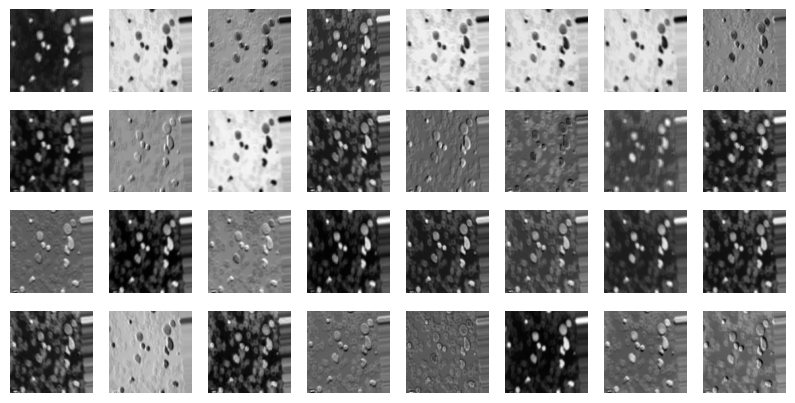

In [59]:
# Use one image from your dataset
# Get a batch of data from the train_loader
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Select the first image from the batch and move it to the same device as the model
img = images[0].to(device)

# Visualize feature maps for the selected image
visualize_feature_maps(model1, img)